 # Distributed Machine Learning Pipeline:  Soil + Weather Dynamics ~ NDVI
 
This tutorial walks thru a machine learning pipeline. Note that this example excludes the *Extract* component in the often referenced *ETL* (extract, transform, learn) machine learning nomenclature.The overall goal of this analysis is to predict NDVI dynamics from soil and lagged precipitation, temperature, and vapor pressure deficit observations. The brief outline of the tutorial is:

1. Read and transform the NDVI, Soil, and Weather data.
2. Merge the three datasets and add 26 weekly lags of precipitation, vpd, and temperature as features.
3. Shuffle and split data into three groups:
  * 3% for hyperparameter optimization (Group 1)
  * 97 % for final model
    * 77.6% (97% * 80%) for final model training (Group 2)
    * 19.4% (97% * 20%) for final model testing (validation) (Group 3)
3. Optimize the hyperparamters in an XGBoost model (Xtreme Gradient Boosting) using a small subset of the data.
4. Using the "best fit" hyperparameters, train the model 77.6% of the data (Group 2).
5. Validation with the test (hold-out) data (19.4% - Group 3)

## Table of Contents
1. [Build a Distributed Cluster](#build-a-distributed-cluster)
2. [Preprocess, Transform, and Merge the Data](#preprocess-transfor-and-merge-the-data)
3. [Machine Learning: XGBoost Model](#machine-learning-xgboost-model)
4. [Interpreting the Model](#interpreting-the-model)

In [1]:
import xarray as xr
from IPython.display import Markdown as md
import dask_jobqueue as jq
import dask
from dask import dataframe as ddf
from dask import array as da
from dask.distributed import Client, wait
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm

## Build a Distributed Cluster<a class="anchor" id="build-a-distributed-cluster"></a>

We will use dask-jobqueue to launch and scale a cluster. For a more detailed example of how this works, please see the other tutorials in the SCINet Geospatial 2020 Workshop. For a quick review, the workflow for defining a cluster and scaling is:<br>
  1. Dask-jobqueue submits jobs to Slurm with an sbatch script
  2. The sbatch scripts define the dask workers with the following info:
    * Partition to launch jobs/workers (```partition```)
    * X number of processes (i.e. dask workers) per sbatch script (```num_processes```).
    * Number of threads/cpus per dask worker (```num_threads_per_process```)
    * Memory allocated per sbatch scipt (```mem```), which is spread evenly between the dask workers.
  3. Scale the cluster to the total # of workers. Needs to be a multiple of num_processes.

In this example, we are defining one process (dask worker) per sbatch script. Each process will have 40 cpus (an entire node). We then scale the cluster to 9 workers, which total 360 threads at 1.15TB of memory.

In [2]:
partition='short,brief-low'
num_processes = 1
num_threads_per_process = 40
mem = 3.2*num_processes*num_threads_per_process
n_cores_per_job = num_processes*num_threads_per_process
container = 'docker://rowangaffney/data_science_im_rs:latest'
env = 'py_geo'
clust = jq.SLURMCluster(queue=partition,
                        processes=num_processes,
                        memory=str(mem)+'GB',
                        cores=n_cores_per_job,
                        interface='ib0',
                        local_directory='$TMPDIR',
                        death_timeout=30,
                        python="singularity -vv exec {} /opt/conda/envs/{}/bin/python".format(container,env),
                        walltime='02:00:00',
                        job_extra=["--output=/dev/null","--error=/dev/null"])
cl=Client(clust)
cl

Client Scheduler: tcp://10.1.8.38:38157 Dashboard: http://10.1.8.38:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


**Note, for now we will need to "port forward" the dask dashboard, but in the future this won't be neccassary**

To port forward the dask dashboard execute the following command (with the appropriate IP and user name) in your terminal or powershell.

```bash
ssh -N -L 8787:10.1.8.XX:8787 USER.NAME@login.scinet.science
```

Where ```10.1.8.XX``` is the IP address of the machine running Jupyter (see the IP address shown in the output of the previous cell), and ```USER.NAME``` is your Ceres user name (e.g. rowan.gaffney).

**View Cluster**
View the cluster with the dask dashboard interaface. To do this click the dask icon (<img src="https://avatars3.githubusercontent.com/u/17131925?s=400&v=4" width=20/>) on the left menu pane. You may need to type ```http:localhost:8787/status``` into the address bar. Then click on the "Workers", "Progress", "Task Stream", and "CPU" tabs. Drag and arrange in convineint layout on right-hand side of the screen. Note these panes should be mostly blank as we have yet to scale the cluster (see below)

**Scale the Cluster** to 9 workers (40 cpus per worker). This may take 5-20 seconds to complete.


In [3]:
#scale the cluster
n_workers=9
clust.scale(n=n_workers*num_processes)
#Wait for the cluster to load, show progress bar.
with tqdm(total=n_workers*num_processes) as pbar:
    while (((cl.status == "running") and (len(cl.scheduler_info()["workers"]) < n_workers*num_processes))):
        pbar.update(len(cl.scheduler_info()["workers"])-pbar.n)
    pbar.update(len(cl.scheduler_info()["workers"])-pbar.n)
cl

Client Scheduler: tcp://10.1.8.38:38157 Dashboard: http://10.1.8.38:8787/status,Cluster Workers: 9 Cores: 360 Memory: 1.15 TB


## Preprocess, Transform, and Merge the Data<a class="anchor" id="preprocess-transfor-and-merge-the-data"></a>

#### Harmonized Landsat Sentinel Data

Link to data repository: https://hls.gsfc.nasa.gov/

**Worksflow:**
  1. Data is stored in the Zarr format with three dimensions (x,y,time).
  2. Read with xarray.
  3. Divide the data into chunks. Here we have chunked the data by: x=20 pixels, y=20 pixels, date=Entire Dataset
  4. Subset the data to only included "growing season" months.
  5. Convert the xarray object to a 2-Dimensional dataframe.
  
Notice that the data is not stored to memory. The only information stored is the "task graph" and metadata about the final results.

In [4]:
#Read the data with Xarray and rechunk
ndvi = xr.open_zarr('./data/ndvi_hls.zarr/').chunk({'x':20,'y':20,'date':-1})
ndvi

,Array,Chunk
Bytes,558.07 MB,2.17 MB
Shape,"(677, 321, 321)","(677, 20, 20)"
Count,676 Tasks,289 Chunks
Type,float64,numpy.ndarray


In [8]:
#Select relevant months and then convert to a dataframe
ndvi_df = ndvi.sel(date=ndvi['date.month'].isin([5,6,7,8,9])).to_dask_dataframe()
#Only include reasonable values (.1 < NDVI < 1.0) in the analysis
ndvi_df = ndvi_df[(ndvi_df.ndvi>.1)&(ndvi_df.ndvi<1.)]
print('There are '+f'{len(ndvi_df):,}'+' NDVI observations.')
ndvi_df

There are 21,872,244 NDVI observations.


,date,x,y,ndvi
npartitions=264,,,,
0,datetime64[ns],float64,float64,float64
103041,...,...,...,...
...,...,...,...,...
27099783,...,...,...,...
27202823,...,...,...,...


#### Polaris Soil Hydraulic Data

Paper Describing the Data: https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2018WR022797<br>
Data Repository Source:  http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/

**Workflow:**
  1. Data is stored in the Zarr format with two dimensions (x,y) and includes 13 variables at 6 depths (78 total). Read with xarray.
  2. Interpolate the data to the same grid as the HLS NDVI data.
  3. Convert the xarray object to a 2-Dimensional Pandas dataframe.

In [9]:
soil = xr.open_zarr('./data/polaris_soils.zarr/')
#Interpolate to the HLS NDVI grid
soil_df = soil.interp(x=ndvi.x,y=ndvi.y,method='linear').squeeze().to_dataframe().reset_index()
soil_df

,x,y,alpha_mean_0_5,alpha_mean_100_200,alpha_mean_15_30,alpha_mean_30_60,alpha_mean_5_15,alpha_mean_60_100,band,bd_mean_0_5,...,theta_r_mean_15_30,theta_r_mean_30_60,theta_r_mean_5_15,theta_r_mean_60_100,theta_s_mean_0_5,theta_s_mean_100_200,theta_s_mean_15_30,theta_s_mean_30_60,theta_s_mean_5_15,theta_s_mean_60_100
0,517635.0,4524345.0,1.373071,1.373071,1.373071,1.373071,1.373071,1.373071,1,1.373071,...,1.373071,1.373071,1.373071,1.373071,1.373071,1.373071,1.373071,1.373071,1.373071,1.373071
1,517635.0,4524315.0,1.353372,1.353372,1.353372,1.353372,1.353372,1.353372,1,1.353372,...,1.353372,1.353372,1.353372,1.353372,1.353372,1.353372,1.353372,1.353372,1.353372,1.353372
2,517635.0,4524285.0,1.387728,1.387728,1.387728,1.387728,1.387728,1.387728,1,1.387728,...,1.387728,1.387728,1.387728,1.387728,1.387728,1.387728,1.387728,1.387728,1.387728,1.387728
3,517635.0,4524255.0,1.407588,1.407588,1.407588,1.407588,1.407588,1.407588,1,1.407588,...,1.407588,1.407588,1.407588,1.407588,1.407588,1.407588,1.407588,1.407588,1.407588,1.407588
4,517635.0,4524225.0,1.403421,1.403421,1.403421,1.403421,1.403421,1.403421,1,1.403421,...,1.403421,1.403421,1.403421,1.403421,1.403421,1.403421,1.403421,1.403421,1.403421,1.403421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103036,527235.0,4514865.0,1.334672,1.334672,1.334672,1.334672,1.334672,1.334672,1,1.334672,...,1.334672,1.334672,1.334672,1.334672,1.334672,1.334672,1.334672,1.334672,1.334672,1.334672
103037,527235.0,4514835.0,1.339076,1.339076,1.339076,1.339076,1.339076,1.339076,1,1.339076,...,1.339076,1.339076,1.339076,1.339076,1.339076,1.339076,1.339076,1.339076,1.339076,1.339076
103038,527235.0,4514805.0,1.355156,1.355156,1.355156,1.355156,1.355156,1.355156,1,1.355156,...,1.355156,1.355156,1.355156,1.355156,1.355156,1.355156,1.355156,1.355156,1.355156,1.355156
103039,527235.0,4514775.0,1.371146,1.371146,1.371146,1.371146,1.371146,1.371146,1,1.371146,...,1.371146,1.371146,1.371146,1.371146,1.371146,1.371146,1.371146,1.371146,1.371146,1.371146


#### PRISM Precipitation, Tempature, and Vapor Pressure Deficit Data

PRISM Data in a CSV file. Note this data was queried at a single point at the center of CPER.

**Workflow:**
  1. Data is stored in the csv format and includes 7 variables. Read with Pandas using:
    * Skip the 1st 10 rows (PRISM metadata)
    * Convert the time column from a generic object to a date-time object.
  2.  Rename the "Date" to "date" to match HLS NDVI data.
  3. Set the "date" column as the index.
  4. Sort the data into descending.

In [10]:
df_env = pd.read_csv('./data/PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_provisional_4km_20120101_20200101_40.8269_-104.7154.csv',
                      skiprows=10,
                      infer_datetime_format=True,
                      parse_dates = ['Date']).rename(columns={'Date':'date'}).set_index('date').sort_index(ascending=False)
df_env

,ppt (mm),tmin (degrees C),tmean (degrees C),tmax (degrees C),tdmean (degrees C),vpdmin (hPa),vpdmax (hPa)
date,,,,,,,
2020-01-01,0.00,-11.5,-4.4,2.8,-13.5,0.94,4.83
2019-12-31,0.00,-12.6,-7.5,-2.3,-16.1,0.77,2.85
2019-12-30,0.00,-9.4,-7.4,-5.4,-15.5,1.04,1.77
2019-12-29,1.49,-7.4,-6.7,-6.1,-10.5,0.25,0.96
2019-12-28,5.22,-5.2,-3.2,-1.2,-4.7,0.22,1.06
...,...,...,...,...,...,...,...
2012-01-05,0.00,-7.0,3.8,14.5,-9.9,0.92,14.55
2012-01-04,0.00,-6.5,3.6,13.7,-10.1,0.91,13.65
2012-01-03,0.00,-11.2,-0.9,9.4,-9.8,0.48,8.72


#### Transform Function to Merge NDVI, Soil, and PRISM data.

Here we develop a class to merge the three dataset. Note the most import code is in the ```def transform``` function.

In [11]:
#Costum transformer in the scikit-learn API syntax
class merge_dsets(BaseEstimator,TransformerMixin):
    def __init__(self, df_soil, df_env,lag):
        self.soil = df_soil
        self.env = df_env
        self.lag = lag
        #self.lag_interv = lag_interval
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        df = df.merge(self.soil, on =['x','y'])
        df_env_m = pd.DataFrame()
        for i,d in enumerate(df.date.unique()):
            df_env_temp = df_env[df_env.index<d+pd.Timedelta('1days')].resample('1W-'+d.day_name()[0:3].upper(),
                                                                                label='right').agg({'ppt (mm)':'sum',
                                                                                                    'tmean (degrees C)':'mean',
                                                                                                    'vpdmin (hPa)':'mean',
                                                                                                    'vpdmax (hPa)':'mean'}).sort_index(ascending=False).iloc[0:self.lag].reset_index().reset_index().rename(columns={'index':'week'})
            df_env_temp = df_env_temp.drop(columns='date').melt(id_vars='week')
            df_env_temp['col']='week'+df_env_temp.week.astype(str)+'_'+df_env_temp.variable.str.split(' ',expand=True).values[:,0]
            df_env_temp = df_env_temp.set_index('col').drop(columns=['week','variable']).T
            df_env_temp['date']=d
            df_env_temp = df_env_temp.set_index('date',drop=True)
            df_env_m = df_env_m.append(df_env_temp)
        df = df.merge(df_env_m,left_on='date',right_index=True)
        return(df.drop(columns=['date','x','y','ndvi']))#.to_dask_array(lengths=True))

## Machine Learning: XGBoost Model<a class="anchor" id="machine-learning-xgboost-model"></a>
The "*learn*" portion in the ETL pipeline.

In [12]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dask_ml.xgboost import XGBRegressor as dask_XGBRegressor
from dask_ml.model_selection import train_test_split
from sklearn.metrics import r2_score
from dask_ml.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV as sk_GridSearchCV
import joblib

### Hyperparameter Optimization

Shuffle and subset data to a *managable size* (e.g. will fit in memory when running 360 simaltaneous models). We will use a grid-search, combined with 3-fold cross validation, approach to optimize the relevant hyperparameters (see table below).

| Hyperparameter  |        Grid       | n |
|------------|-------------------|---|
|n_estimators | [150, 250, 300, 350] | 4 |
|learning_rate| [0.05, 0.1, 0.2, 0.3]|4|
|max_depth|[5, 7, 9, 11]|4|
|colsample_bytree|[.1, .2, .3]|3|
|gamma|[.05, .1, .2]|3|

A total of 1728 models (4 * 4 * 4 * 3 * 3 * 3) will be fit. The hyperparameters assocated with the best scoring model (highest R2) will be used to train the remianing data.

This search can take ~1-2 hour using 360 cores. To run the hyperparameter gridsearch cross validation, set the ```optimize_hyperparameter``` variable to ```True``` (see two cells below). If you leave as ```False```, we will skip the hyperparameter calculatoins, and just use the hyperparameter values previously calculated.

In [14]:
X_train_hyp, X,Y_train_hyp, Y = train_test_split(ndvi_df,
                                                 ndvi_df[['ndvi']],
                                                 test_size=0.97,
                                                 shuffle=True,
                                                 random_state=34)
X_train_hyp,Y_train_hyp = dask.compute(*[merge_dsets(df_soil=soil_df,
                                                     df_env=df_env,
                                                     lag=26).transform(X_train_hyp),
                                         Y_train_hyp])
X_train_hyp

,alpha_mean_0_5,alpha_mean_100_200,alpha_mean_15_30,alpha_mean_30_60,alpha_mean_5_15,alpha_mean_60_100,band,bd_mean_0_5,bd_mean_100_200,bd_mean_15_30,...,week16_vpdmax,week17_vpdmax,week18_vpdmax,week19_vpdmax,week20_vpdmax,week21_vpdmax,week22_vpdmax,week23_vpdmax,week24_vpdmax,week25_vpdmax
0,1.428966,1.428966,1.428966,1.428966,1.428966,1.428966,1,1.428966,1.428966,1.428966,...,6.845714,4.095714,3.082857,7.395714,6.590000,10.048571,10.514286,13.182857,6.598571,11.681429
1,1.354757,1.354757,1.354757,1.354757,1.354757,1.354757,1,1.354757,1.354757,1.354757,...,6.845714,4.095714,3.082857,7.395714,6.590000,10.048571,10.514286,13.182857,6.598571,11.681429
2,1.363482,1.363482,1.363482,1.363482,1.363482,1.363482,1,1.363482,1.363482,1.363482,...,6.845714,4.095714,3.082857,7.395714,6.590000,10.048571,10.514286,13.182857,6.598571,11.681429
3,1.339603,1.339603,1.339603,1.339603,1.339603,1.339603,1,1.339603,1.339603,1.339603,...,6.845714,4.095714,3.082857,7.395714,6.590000,10.048571,10.514286,13.182857,6.598571,11.681429
4,1.394900,1.394900,1.394900,1.394900,1.394900,1.394900,1,1.394900,1.394900,1.394900,...,6.845714,4.095714,3.082857,7.395714,6.590000,10.048571,10.514286,13.182857,6.598571,11.681429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,1.350178,1.350178,1.350178,1.350178,1.350178,1.350178,1,1.350178,1.350178,1.350178,...,22.778571,11.891429,7.457143,22.672857,7.455714,10.165714,13.491429,16.660000,10.317143,11.458571
2998,1.372815,1.372815,1.372815,1.372815,1.372815,1.372815,1,1.372815,1.372815,1.372815,...,22.778571,11.891429,7.457143,22.672857,7.455714,10.165714,13.491429,16.660000,10.317143,11.458571
2999,1.370619,1.370619,1.370619,1.370619,1.370619,1.370619,1,1.370619,1.370619,1.370619,...,22.778571,11.891429,7.457143,22.672857,7.455714,10.165714,13.491429,16.660000,10.317143,11.458571
3000,1.480464,1.480464,1.480464,1.480464,1.480464,1.480464,1,1.480464,1.480464,1.480464,...,22.778571,11.891429,7.457143,22.672857,7.455714,10.165714,13.491429,16.660000,10.317143,11.458571


In [15]:
optimize_hyperparameters = False

In [16]:
if optimize_hyperparameters:
    #Define the grid - space
    param_dist = {'n_estimators': [150,250,300,350],
        'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'max_depth': [5, 7, 9, 11],
        'colsample_bytree': [.1, .2, .3],
        'gamma': [.05, .1, .2]}
    #Define the XGBoost model
    reg = xgb.XGBRegressor(n_jobs=1,verbosity=3)
    #Setup the GridsearchCV function
    gs = GridSearchCV(reg,param_dist,cv=3,scheduler=cl,refit=False)
    #Fit all the models
    gs.fit(X_train_hyp.values,Y_train_hyp.values)
    #Get the best fitting parameters
    df_params = pd.DataFrame(gs.cv_results_)
    best_params = df_params[df_params.mean_test_score==df_params.mean_test_score.max()]
    best_params = best_params.params.values[0]
    print(best_params)
else:
    #Best fit parameters from previous run
    best_params = {'colsample_bytree': 0.2,
                   'gamma': 0.2,
                   'learning_rate': 0.1,
                   'max_depth': 9,
                   'n_estimators': 350}
    print('Using the previously calculated parameters, which are:')
    print(best_params)

{'colsample_bytree': 0.2, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 350}


### Distributed XGBoost Model

 *  Shuffle and split data into "training" (80%) and "testing" (20%). Leave as dask dataframes (data needs to be distributed across all workers), so we will call ```dask.persist``` to trigger the calculation (rather than dask.compute).
 *  Train XGBoost model using the training data.
 *  Model Validation / Accuracy (r2) with "testing" data

In [17]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                   Y,
                                                   test_size=0.2,
                                                   shuffle=True)
#Persist the data across the cluster
X_train,X_test,Y_train,Y_test = dask.persist(*[merge_dsets(df_soil=soil_df,df_env=df_env,lag=26).transform(X_train),
                                               merge_dsets(df_soil=soil_df,df_env=df_env,lag=26).transform(X_test),
                                               Y_train,
                                               Y_test])
wait([X_train,X_test,Y_train,Y_test])
X_train

,alpha_mean_0_5,alpha_mean_100_200,alpha_mean_15_30,alpha_mean_30_60,alpha_mean_5_15,alpha_mean_60_100,band,bd_mean_0_5,bd_mean_100_200,bd_mean_15_30,bd_mean_30_60,bd_mean_5_15,bd_mean_60_100,clay_mean_0_5,clay_mean_100_200,clay_mean_15_30,clay_mean_30_60,clay_mean_5_15,clay_mean_60_100,hb_mean_0_5,hb_mean_100_200,hb_mean_15_30,hb_mean_30_60,hb_mean_5_15,hb_mean_60_100,ksat_mean_0_5,ksat_mean_100_200,ksat_mean_15_30,ksat_mean_30_60,ksat_mean_5_15,ksat_mean_60_100,lambda_mean_0_5,lambda_mean_100_200,lambda_mean_15_30,lambda_mean_30_60,lambda_mean_5_15,lambda_mean_60_100,n_mean_0_5,n_mean_100_200,n_mean_15_30,n_mean_30_60,n_mean_5_15,n_mean_60_100,om_mean_0_5,om_mean_100_200,om_mean_15_30,om_mean_30_60,om_mean_5_15,om_mean_60_100,ph_mean_0_5,ph_mean_100_200,ph_mean_15_30,ph_mean_30_60,ph_mean_5_15,ph_mean_60_100,sand_mean_0_5,sand_mean_100_200,sand_mean_15_30,sand_mean_30_60,sand_mean_5_15,sand_mean_60_100,silt_mean_0_5,silt_mean_100_200,silt_mean_15_30,silt_mean_30_60,silt_mean_5_15,silt_mean_60_100,theta_r_mean_0_5,theta_r_mean_100_200,theta_r_mean_15_30,theta_r_mean_30_60,theta_r_mean_5_15,theta_r_mean_60_100,theta_s_mean_0_5,theta_s_mean_100_200,theta_s_mean_15_30,theta_s_mean_30_60,theta_s_mean_5_15,theta_s_mean_60_100,week0_ppt,week1_ppt,week2_ppt,week3_ppt,week4_ppt,week5_ppt,week6_ppt,week7_ppt,week8_ppt,week9_ppt,week10_ppt,week11_ppt,week12_ppt,week13_ppt,week14_ppt,week15_ppt,week16_ppt,week17_ppt,week18_ppt,week19_ppt,week20_ppt,week21_ppt,week22_ppt,week23_ppt,week24_ppt,week25_ppt,week0_tmean,week1_tmean,week2_tmean,week3_tmean,week4_tmean,week5_tmean,week6_tmean,week7_tmean,week8_tmean,week9_tmean,week10_tmean,week11_tmean,week12_tmean,week13_tmean,week14_tmean,week15_tmean,week16_tmean,week17_tmean,week18_tmean,week19_tmean,week20_tmean,week21_tmean,week22_tmean,week23_tmean,week24_tmean,week25_tmean,week0_vpdmin,week1_vpdmin,week2_vpdmin,week3_vpdmin,week4_vpdmin,week5_vpdmin,week6_vpdmin,week7_vpdmin,week8_vpdmin,week9_vpdmin,week10_vpdmin,week11_vpdmin,week12_vpdmin,week13_vpdmin,week14_vpdmin,week15_vpdmin,week16_vpdmin,week17_vpdmin,week18_vpdmin,week19_vpdmin,week20_vpdmin,week21_vpdmin,week22_vpdmin,week23_vpdmin,week24_vpdmin,week25_vpdmin,week0_vpdmax,week1_vpdmax,week2_vpdmax,week3_vpdmax,week4_vpdmax,week5_vpdmax,week6_vpdmax,week7_vpdmax,week8_vpdmax,week9_vpdmax,week10_vpdmax,week11_vpdmax,week12_vpdmax,week13_vpdmax,week14_vpdmax,week15_vpdmax,week16_vpdmax,week17_vpdmax,week18_vpdmax,week19_vpdmax,week20_vpdmax,week21_vpdmax,week22_vpdmax,week23_vpdmax,week24_vpdmax,week25_vpdmax
npartitions=264,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

In [18]:
#Setup the Distributed XGBoost model
dtrain = xgb.dask.DaskDMatrix(cl, X_train, Y_train)
reg_b = xgb.dask.train(cl,
                       best_params,
                       dtrain,
                       num_boost_round=30,
                       evals=[(dtrain, 'train')])
print(reg_b)

{'booster': <xgboost.core.Booster object at 0x2b29ddf92610>, 'history': {'train': {'rmse': [0.196511, 0.178849, 0.163002, 0.148893, 0.136639, 0.125577, 0.11583, 0.107302, 0.099851, 0.093396, 0.087787, 0.082967, 0.078848, 0.075337, 0.072355, 0.069854, 0.067749, 0.06601, 0.064555, 0.063353, 0.062353, 0.061533, 0.06086, 0.060301, 0.059843, 0.059473, 0.059171, 0.058918, 0.058713, 0.058543]}}}


In [19]:
#Get the R2 results for the testing data
dtest = xgb.dask.DaskDMatrix(cl, X_test, Y_test)
pred = xgb.dask.predict(cl, reg_b['booster'], dtest)
reg_r2 = r2_score(Y_test.ndvi.compute().values,pred)
print("The overall R2 is: "+str(reg_r2))

The overall R2 is: 0.6195558077072203


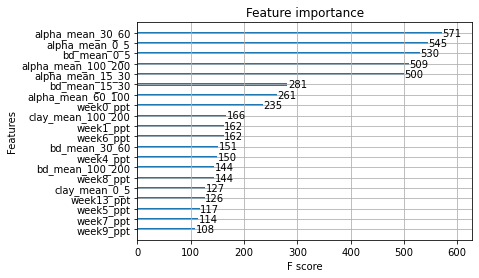

In [20]:
#Show the top 20 most import features as defined by the XGBoost model software
xgb.plot_importance(reg_b['booster'],max_num_features=20)

## Interpreting the Model<a class="anchor" id="interpreting-the-model"></a>

**Coming Soon - use the [shap package](https://github.com/slundberg/shap)**

SHAP Papers: https://www.nature.com/articles/s42256-019-0138-9 and http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions

SHAP Blog: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27